In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import collections
import os
import shutil
import random
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from nltk.corpus import stopwords
mails = pd.read_csv('E:/spam filtering/New folder/smsspamcollectiondataset/smsspamcollectiondataset/spam.csv', encoding = 'latin-1')
mails.head()


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [7]:
mails.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1, inplace = True)
mails.head(1)

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."


In [8]:
mails.rename(columns = {'v1': 'spam', 'v2': 'message'}, inplace = True)
mails.head(1)

,spam,message
0,ham,"Go until jurong point, crazy.. Available only ..."


In [9]:
mails['spam'] = mails['spam'].map({'ham': False, 'spam': True})
mails.head()

,spam,message
0,False,"Go until jurong point, crazy.. Available only ..."
1,False,Ok lar... Joking wif u oni...
2,True,Free entry in 2 a wkly comp to win FA Cup fina...
3,False,U dun say so early hor... U c already then say...
4,False,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
mails['spam'].value_counts()

spam
False    4825
True      747
Name: count, dtype: int64

In [11]:
all_mails_count = mails['spam'].count()

train_data = mails.loc[:all_mails_count*0.70]
train_data['spam'].value_counts()

spam
False    3382
True      519
Name: count, dtype: int64

In [12]:
test_data = mails.loc[all_mails_count*0.70 + 1:]
test_data.reset_index(inplace = True)
test_data['spam'].value_counts()

spam
False    1442
True      228
Name: count, dtype: int64

In [14]:
def count_words(data):
    counter = collections.OrderedDict()
    for message in data:
        for word in message.split(' '):
            if word in counter:
                counter[word] += 1
            else:
                counter[word] = 1
    return counter

In [15]:
spam_messages = set(train_data[train_data['spam'] == True]['message'])
spam_words = count_words(spam_messages)
ham_messages = set(train_data[train_data['spam'] == False]['message'])
ham_words = count_words(ham_messages)

In [16]:
def bar_chart_words(words, top=10, messages_type="", color="#1f77b4"):
    top_spam = np.array(sorted(words.items(), key=lambda x: -x[1]))[:top]
    top_words = top_spam[ : :-1, 0]
    top_words_count = [int(i) for i in top_spam[ : :-1, 1]]
    # aesthetics
    if messages_type:
        messages_type = messages_type + " " 
    plt.title(f"Top {top} most common words in {messages_type}messages")
    plt.xlabel(f"Number of words")
    plt.barh(top_words, top_words_count, color=color)
    plt.show()

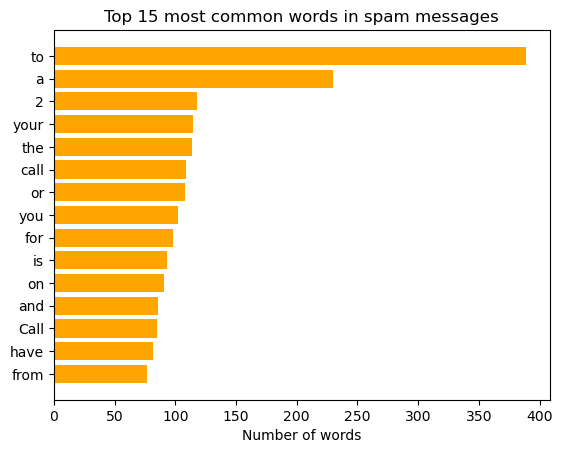

In [17]:
bar_chart_words(spam_words, top=15, messages_type="spam", color="orange")


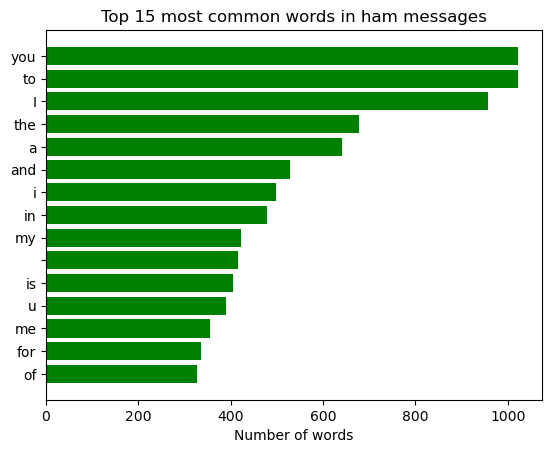

In [18]:
bar_chart_words(ham_words, top=15, messages_type="ham", color="green")


In [21]:
words = pd.read_csv('E:/spam filtering/New folder/english/english/words.csv', encoding='UTF-8', header=None)
words.rename(columns={0: 'words'}, inplace=True)
wordlist = set(words['words'])

In [22]:
stop_words = stopwords.words('english')


In [23]:
def process_message(message):  
    words = message.lower() # lowercase
    words = word_tokenize(words) # tokenization
    words = [word for word in words if len(word) > 1] # non absurd words          
    words = [word for word in words if word not in stop_words] # non stop words
    words = [word for word in words if word in wordlist] # english words
    words = [PorterStemmer().stem(word) for word in words] # stemming
    return words

In [24]:
def count_processed_words(data):
    counter = collections.OrderedDict()
    for message in data:
        words = process_message(message)
        for word in set(words):           
            if word in counter:
                counter[word] += 1
            else:
                counter[word] = 1
    return counter

In [25]:
spam_words = count_processed_words(spam_messages)
ham_words = count_processed_words(ham_messages)

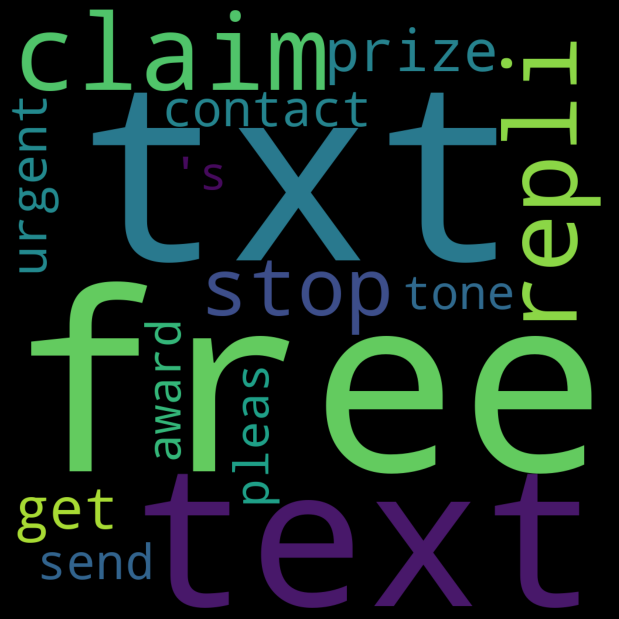

In [26]:
spam_wc = WordCloud(width = 1024,height = 1024, max_words=15).generate_from_frequencies(spam_words)
plt.figure(figsize = (8, 6), facecolor='k')
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

In [28]:
spam_messages = [i for i in spam_messages if len(process_message(i)) >= 1]
ham_messages = [i for i in ham_messages if len(process_message(i)) >= 1]

In [29]:
all_messages = spam_messages + ham_messages
all_words = count_processed_words(all_messages)

In [31]:
def spam(message, s=1, p=0.5, percentage=False):
    '''
    message - needs to be a non-empty string value for valid result
    s - the strength we give to background information about incoming spam, default is 1 
    p - the probability of any incoming message to be spam, default is 0.5
    percentage - returns result as boolean or a percentage, default is True
    '''
    n = 0
    spam_freq = 0
    ham_freq = 0
    for word in process_message(message):
        
        if word in spam_words.keys(): 
            # count of spam messages containing the word / count of all messages containing the word
            spam_freq = (spam_words[word] / all_words[word])
        if word in ham_words.keys():
            # count of ham messages containing the word / count of all messages containing the word
            ham_freq = (ham_words[word] / all_words[word])
            
        # if word is not in trained dataset we ignore it    
        if not (spam_freq + ham_freq) == 0 and word in all_words.keys(): 
            spaminess_of_word = (spam_freq ) / (spam_freq  + ham_freq )
            corr_spaminess = (s * p + all_words[word] * spaminess_of_word) / (s + all_words[word])            
            n += np.log(1 - corr_spaminess) - np.log(corr_spaminess)

    spam_result = 1 / (1 + np.e**n)
    
    if percentage:
        print(f'Spam probability: {spam_result*100:.2f}%')
    elif spam_result > 0.5:    
        return True
    else:
        return False

In [32]:
spam("Join SoftUni, FREE Programming Basics course! Don't miss out on this offer! Become a code wizard GUARANTEED!")

True

In [33]:
spam("Hey man, SoftUni is pretty great. This Data Science course? Highly recommend.")

False

In [34]:
spam("Call me when you get home", percentage=True)


Spam probability: 19.76%


In [35]:
spam("Call me now to win a FREE home!", percentage=True)

Spam probability: 74.11%


In [36]:
spam("Call now to win a FREE prize!", percentage=True)

Spam probability: 91.52%


In [38]:
def test(spam_test, ham_test, s=1, p=0.5, details=False):
    '''
    spam_test - list of spam messages to be tested
    ham_test - list of ham messages to be tested
    details - displays additional information
    '''
    spam_count = 0
    ham_count = 0
    for message in spam_test:
        if spam(message, s, p):
            spam_count += 1
        else:
            ham_count += 1

    true_positive = spam_count
    false_negative = ham_count
    

    spam_count = ham_count = 0
    for message in ham_test:
        if spam(message, s, p):
            spam_count += 1
        else:
            ham_count += 1
    
    false_positive = spam_count
    true_negative = ham_count

    # How many selected messages are spam?
    spam_precision = true_positive / (true_positive + false_positive)
    
    # How many spam messages are selected?
    spam_recall = true_positive / (true_positive + false_negative)
    
    # Harmonic mean between precision and recall.
    spam_fscore = 2 * (spam_precision * spam_recall) / (spam_precision + spam_recall) 
    # How many selected messages are ham?
    ham_precision = true_negative / (true_negative + false_negative)
    
    # How many ham messages are selected?
    ham_recall = true_negative / (true_negative + false_positive)
    
    # Harmonic mean between precision and recall.
    ham_fscore = 2 * (ham_precision * ham_recall) / (ham_precision + ham_recall)
    
    # If the data was ballanced.
    # accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)
    
    # For unballanced data.
    ballanced_accuracy = ( spam_recall + ham_recall ) / 2
    
    if details:
        print("True Positive: ", true_positive)
        print("False Negative:", false_negative)
        print("True Negative: ", true_negative)
        print(f"False Positive: {false_positive}\n")
        
        print(f"Spam precision: {spam_precision*100:.2f}%")
        print(f"Spam recall: {spam_recall*100:.2f}%")
        print(f"Spam F-score: {spam_fscore*100:.2f}%\n")
        
        print(f"Ham precision: {ham_precision*100:.2f}%")
        print(f"Ham recall: {ham_recall*100:.2f}%")
        print(f"Ham F-score: {ham_fscore*100:.2f}%\n")
        
    print(f"Accuracy: {ballanced_accuracy*100:.2f}%\n")

In [39]:
test_spam_messages = set(test_data[test_data['spam'] == True]['message'])
test_spam_messages = [i for i in test_spam_messages if len(process_message(i)) >= 1]


test_ham_messages = set(test_data[test_data['spam'] == False]['message'])
test_ham_messages = [i for i in test_ham_messages if len(process_message(i)) >= 1]

In [40]:
test(spam_test=test_spam_messages, ham_test=test_ham_messages, details=True)

True Positive:  142
False Negative: 75
True Negative:  1331
False Positive: 25

Spam precision: 85.03%
Spam recall: 65.44%
Spam F-score: 73.96%

Ham precision: 94.67%
Ham recall: 98.16%
Ham F-score: 96.38%

Accuracy: 81.80%



In [47]:
# Define a function to classify a message as spam or ham
def spam(message):
    # Simple heuristic: if the message contains "free" or "exclusive", it's likely spam
    keywords = ["free", "exclusive", "win", "trial"]
    for keyword in keywords:
        if keyword in message.lower():
            return True
    return False

# Generate a list of 50 incoming messages (20 spam, 30 ham)
incoming_messages = []
for i in range(50):
    if i < 20:  # generate 20 spam messages
        message = f"Spam message {i}: {random.choice(['Win a free iPhone now!', 'Exclusive offer just for you', 'Get your free trial now!', 'Limited time offer!'])}"
    else:  # generate 30 ham messages
        message = f"Ham message {i}: {random.choice(['Meeting tomorrow at 10 AM', 'Lunch at 1 PM?', 'Hello, how are you?', 'See you later!'])}"
    incoming_messages.append(message)

spam_dir = "spam_folder"
ham_dir = "ham_folder"

os.makedirs(spam_dir, exist_ok=True)
os.makedirs(ham_dir, exist_ok=True)

# Filter and store the messages
spam_count = 0
ham_count = 0
for i, message in enumerate(incoming_messages):
    if spam(message):
        with open(os.path.join(spam_dir, f"spam_{i}.txt"), "w") as f:
            f.write(message)
        spam_count += 1
    else:
        with open(os.path.join(ham_dir, f"ham_{i}.txt"), "w") as f:
            f.write(message)
        ham_count += 1

print(f"Messages filtered and stored: {spam_count} spam, {ham_count} ham")

Messages filtered and stored: 15 spam, 35 ham


## 